In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle
import os

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2019
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
types_cit = ['self','co','others']

In [6]:
authors_info = {}
with open(path+'authors_info.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2])]

In [7]:
#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)

In [8]:
for disc in list_disciplines:
    authors_disc_idx[disc] = {authors_disc_idx[disc][x]:x for x in authors_disc_idx[disc]}

In [9]:
from matplotlib import pyplot as plt

### Get % for start year and age

In [10]:
plot_years = [0,1,2,3,4,5]

In [12]:
for i in range(nb_disciplines):
    disc = list_disciplines[i]
    arrays_refs = {}
    arrays_cits = {}
    for type_cit in types_cit:
        arrays_cits[type_cit] = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        arrays_refs[type_cit] = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    total_refs_cumul = np.sum(total_refs,axis=1)
    total_cits_cumul = np.sum(total_cits,axis=1)
    rows_refs = np.where(total_refs_cumul)[0]
    rows_cits = np.where(total_cits_cumul)[0]

    plot_types = ['self','co']
    stats_refs = {}
    stats_cits = {}

    keys = list(authors_disc_idx[disc])
    keys.sort()
    auth_idx_disc = [authors_disc_idx[disc][idx] for idx in keys]
    year_start = [authors_info[ID][1] for ID in auth_idx_disc]

    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
        arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

        idx_cits = total_cits.nonzero()
        idx_refs = total_refs.nonzero()
        arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
        arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

        count_cits = np.count_nonzero(total_cits,axis=1)
        idx_count_cits = np.where(count_cits)[0]
        #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_cits)
        for j in range(nb_authors):
            idx_author = idx_count_cits[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_cits[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1     


        stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_cits = total.nonzero()
        stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])





        count_refs = np.count_nonzero(total_refs,axis=1)
        idx_count_refs = np.where(count_refs)[0]
        #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_refs)
        for j in range(nb_authors):
            idx_author = idx_count_refs[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_refs[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1    


        stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_refs = total.nonzero()
        stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])
    plt.figure(figsize=(12,8))
    for j in plot_years:
        xaxis = np.arange(min_year,max_year-j)
        nb_x = len(xaxis)
        idx_year = plot_years[j]
        plt.subplot(2,3,j+1)
        plt.plot(xaxis,stats_cits['self_perc_year'][idx_year,:nb_x],'r',label='% direct cits')
        plt.plot(xaxis,stats_cits['co_perc_year'][idx_year,:nb_x],'r--',label='% indirect cits')
        plt.plot(xaxis,stats_refs['self_perc_year'][idx_year,:nb_x],'g',label='% direct refs')
        plt.plot(xaxis,stats_refs['co_perc_year'][idx_year,:nb_x],'g--',label='% indirect cits')
        plt.xlim([min_year,max_year])
        plt.title('Academic age: ' + str(idx_year+1))
        if j == 0:
            plt.legend()

    out_path = path+'results/fig_cross_section/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + disc + '.png')
    plt.close()


KeyboardInterrupt: 

In [19]:
stats_cits['self_perc_year'][idx_year,:]

array([39.01038277, 32.98330647, 32.15167678, 30.01348265, 30.76273498,
       30.55571008, 28.41869982, 27.01640859, 26.2553039 , 26.02221605,
       25.51212952, 24.56020649, 22.99986562, 21.37402346, 21.50614391,
       21.90811922, 19.35124748, 20.21681502, 17.32088655, 17.41088928,
       15.81029634, 13.89872082, 12.22404056, 11.91502759, 11.18960634,
        9.54353778,  8.9474566 ,  7.38944462,  7.0821448 ,  7.12901348,
        6.0649814 ,  5.36832794,  5.05807738,  4.70768476,  4.52736425,
        4.56858736,  4.15744692,  5.33904755,  7.59818988])

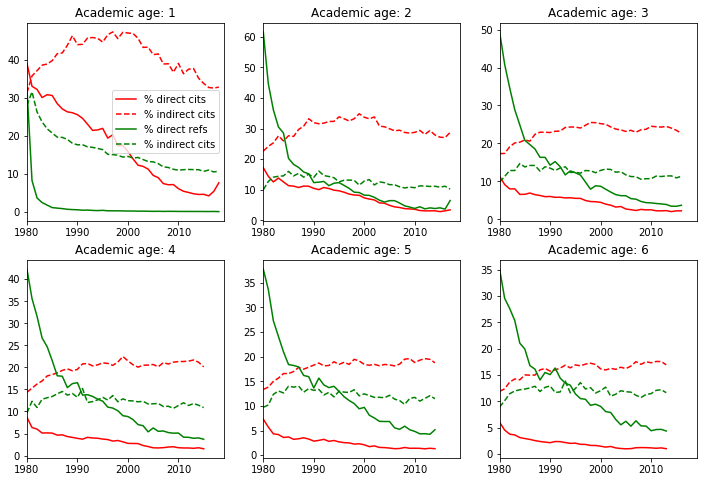

In [22]:
plt.figure(figsize=(12,8))
for j in plot_years:
    xaxis = np.arange(min_year,max_year-j)
    nb_x = len(xaxis)
    idx_year = plot_years[j]
    plt.subplot(2,3,j+1)
    plt.plot(xaxis,stats_cits['self_perc_year'][idx_year,:nb_x],'r',label='% direct cits')
    plt.plot(xaxis,stats_cits['co_perc_year'][idx_year,:nb_x],'r--',label='% indirect cits')
    plt.plot(xaxis,stats_refs['self_perc_year'][idx_year,:nb_x],'g',label='% direct refs')
    plt.plot(xaxis,stats_refs['co_perc_year'][idx_year,:nb_x],'g--',label='% indirect cits')
    plt.xlim([min_year,max_year])
    plt.title('Academic age: ' + str(idx_year+1))
    if j == 0:
        plt.legend()
plt.show()